# silver price

## Load the data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme, genpareto
import scipy

# Load dataset
df = pd.read_csv('silver.csv')
df.head()

,Date,USD
0,2022-04-21,24.645
1,2022-04-20,25.200
2,2022-04-19,25.915
3,2022-04-14,25.655
4,2022-04-13,25.640


## Handle missing values

Reads the silver price dataset (silver.csv) into a Pandas DataFrame.    
Converts the Date column into datetime format.  
Fills in any missing values using forward fill (ffill()).   
Computes daily percentage changes in silver price to analyze returns.   
Drops any missing values from the computed returns (rate_change).   

In [5]:
# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'])
# Handle missing values (forward-fill method)
df['USD'] = df['USD'].ffill()
# Compute rate changes (percentage change in Silver price)
df['rate_change'] = df['USD'].pct_change()
# Remove NaN from first difference
df = df.dropna()

## Summary statistics 

In [6]:
display(df.describe())

# kurtosis and skewness
print("Kurtosis:", df['rate_change'].kurtosis())
print("Skewness:", df['rate_change'].skew())


,Date,USD,rate_change
count,13735,13735.000000,13735.000000
mean,1995-02-17 17:47:23.567528320,9.854905,0.000085
min,1968-01-02 00:00:00,1.272000,-0.449233
25%,1981-07-16 12:00:00,4.610000,-0.009673
50%,1995-02-16 00:00:00,5.984000,0.000000
75%,2008-09-17 12:00:00,14.840000,0.008988
max,2022-04-20 00:00:00,49.450000,0.876923
std,NaN,8.002647,0.023231


Kurtosis: 170.08472583582983
Skewness: 3.9519387610305463


## Plot Silver Prices

Plots silver price in USD over time.    
Helps visualize major price spikes and crashes (e.g., around 1980 and 2011).

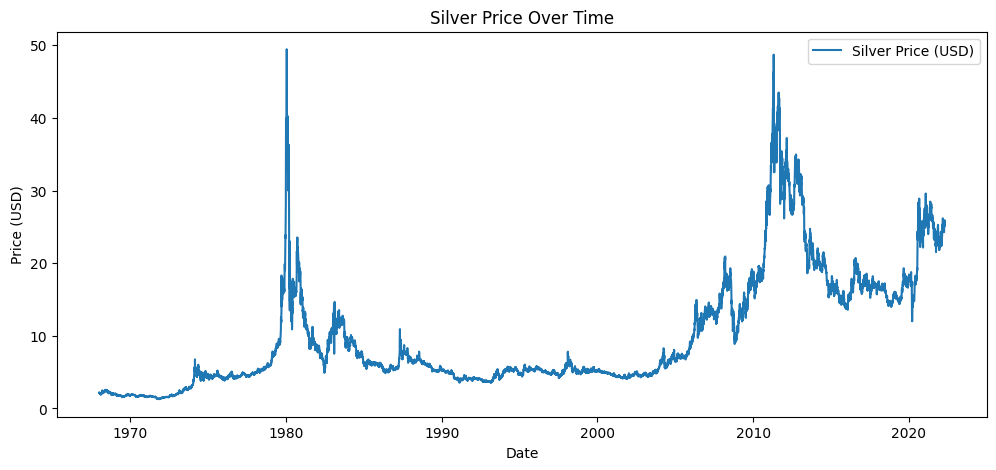

In [7]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['USD'], label='Silver Price (USD)')
plt.title('Silver Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

## Daily Returns Over Time

Plots daily percentage changes.     
Highlights volatility and extreme price movements.  
The red dashed line at 0% helps see when the price is increasing or decreasing. 

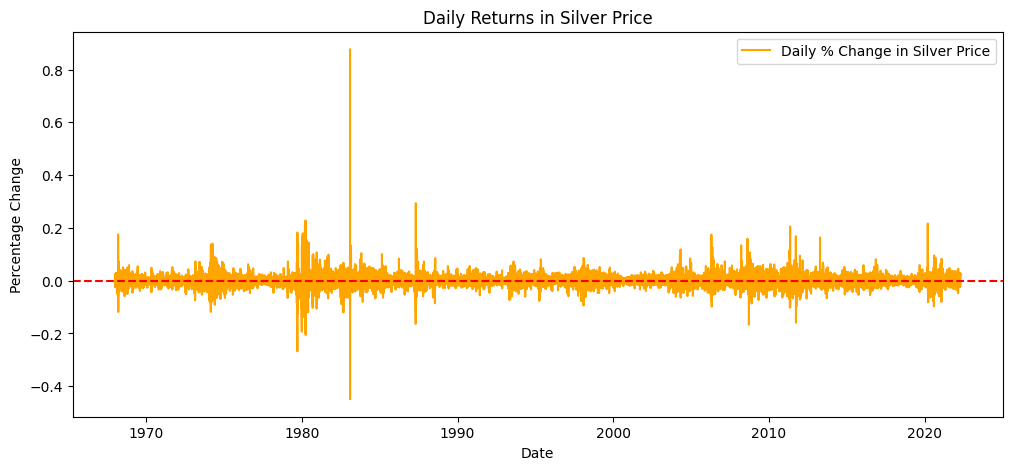

In [8]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['rate_change'], label='Daily % Change in Silver Price', color='orange')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Daily Returns in Silver Price')
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.legend()
plt.show()

Daily Returns Over Time shows percentage changes in silver price (daily returns), highlighting volatility.

---

## Distribution of Returns

Shows the distribution of daily returns.    
Tall central peak suggests most days have small price changes.  
Fat tails (values far from 0) indicate occasional extreme price moves.  

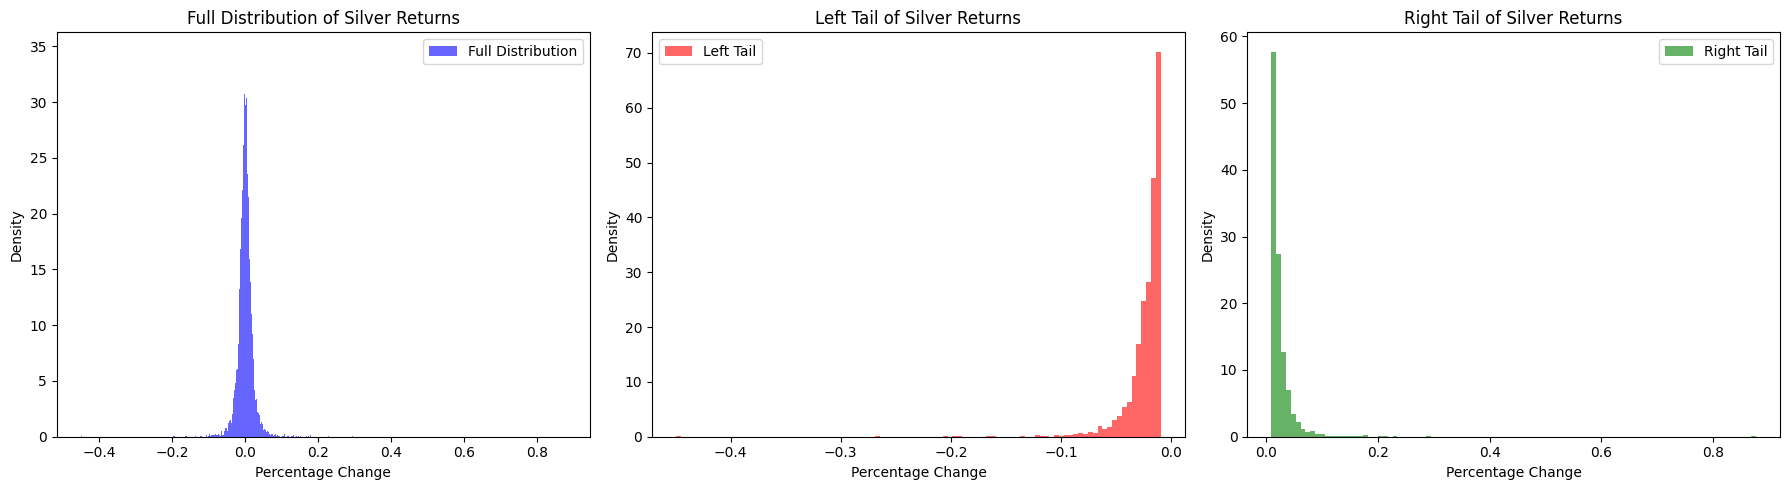

In [9]:
# Extract left and right tails
left_tail = df[df['rate_change'] < df['rate_change'].quantile(0.25)]['rate_change']
right_tail = df[df['rate_change'] > df['rate_change'].quantile(0.75)]['rate_change']

# Create subplots for full distribution, left tail, and right tail
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Full Distribution
axes[0].hist(df['rate_change'], bins=1000, density=True, alpha=0.6, color='b', label='Full Distribution')
axes[0].set_title('Full Distribution of Silver Returns')
axes[0].set_xlabel('Percentage Change')
axes[0].set_ylabel('Density')
axes[0].legend()

# Left Tail Distribution
axes[1].hist(left_tail, bins=100, density=True, alpha=0.6, color='r', label='Left Tail')
axes[1].set_title('Left Tail of Silver Returns')
axes[1].set_xlabel('Percentage Change')
axes[1].set_ylabel('Density')
axes[1].legend()

# Right Tail Distribution
axes[2].hist(right_tail, bins=100, density=True, alpha=0.6, color='g', label='Right Tail')
axes[2].set_title('Right Tail of Silver Returns')
axes[2].set_xlabel('Percentage Change')
axes[2].set_ylabel('Density')
axes[2].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

Histogram of Returns shows the distribution of daily returns, which:
- Has a sharp peak around 0, meaning most days have small price movements.
- Shows some tails, meaning extreme price jumps or crashes dont follow the normal distribution tail.
---

## Block Maxima & Minima

Groups data into 1-month blocks and selects:     
The maximum return (biggest price hike).    
The minimum return (biggest price cut).     

In [10]:
# Block Maxima Method for hikes (positive changes)
df['year_month'] = df['Date'].dt.to_period('M')
block_maxima_hikes = df.groupby('year_month')['rate_change'].max()

# Block Minima Method for cuts (negative changes)
block_minima_cuts = df.groupby('year_month')['rate_change'].min()

## Fitting the Generalized Extreme Value (GEV) Distribution

1. Fits the GEV distribution to:   
- Maxima (Hikes) → Models large positive returns.
- Minima (Cuts) → Models large negative returns.    
2. GEV Parameters:
- Shape (ξ): Determines tail heaviness.
- Location (μ): Center of distribution.
- Scale (σ): Spread of extreme values.

If the shape parameter ξ > 0, the distribution has a heavy tail (extreme events are more likely).   
If ξ < 0, the distribution has a short tail (extremes are limited).     
If ξ ≈ 0, the distribution resembles a Gumbel (light-tailed) distribution.

3. Q-Q Plots for GEV Fit    

- Compare actual quantiles vs. theoretical quantiles.     
- If the points closely follow the diagonal line, the GEV model fits well.    
- Deviations from the line suggest the model may not perfectly capture the extremes.

GEV Parameters (Hikes - Shape, Location, Scale): (np.float64(-0.3749900044954879), np.float64(0.024719034570038448), np.float64(0.012680754935385462))
GEV Parameters (Cuts - Shape, Location, Scale): (np.float64(-0.3052539949472552), np.float64(0.02379808411662912), np.float64(0.012160559686378906))


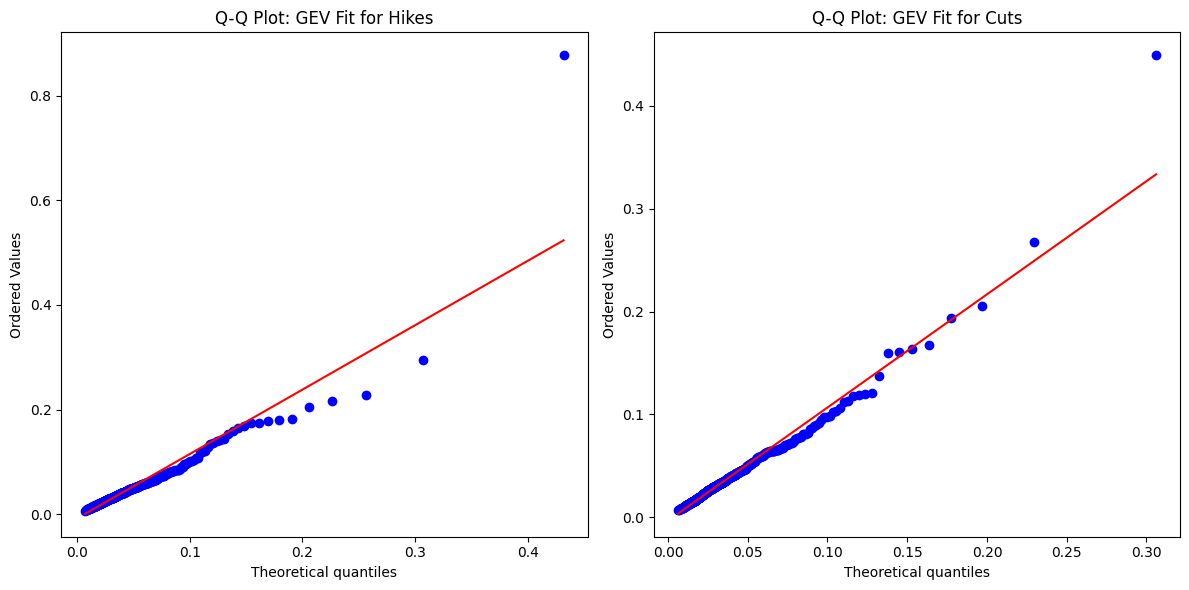

In [11]:
# Fit GEV Distribution for hikes
gev_params_hikes = genextreme.fit(block_maxima_hikes)
print("GEV Parameters (Hikes - Shape, Location, Scale):", gev_params_hikes)

# Fit GEV Distribution for cuts
gev_params_cuts = genextreme.fit(-block_minima_cuts)  # Negate values to fit correctly
print("GEV Parameters (Cuts - Shape, Location, Scale):", gev_params_cuts)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Q-Q Plot for Block Maxima Hikes
scipy.stats.probplot(block_maxima_hikes, dist=genextreme, sparams=gev_params_hikes, plot=axes[0])
axes[0].set_title("Q-Q Plot: GEV Fit for Hikes")
# Q-Q Plot for Block Minima Cuts
scipy.stats.probplot(-block_minima_cuts, dist=genextreme, sparams=gev_params_cuts, plot=axes[1])
axes[1].set_title("Q-Q Plot: GEV Fit for Cuts")
# Adjust layout
plt.tight_layout()
plt.show()

1. spikes

ξ = -0.375 (Negative Shape Parameter) → This suggests that extreme positive returns (hikes) have a bounded tail, meaning there is a natural limit to how large silver price increases can be.   
μ = 0.0247 → The typical extreme price hike is around +2.47% over the block period.     
σ = 0.0127 → The spread of extreme hikes is 1.27%, meaning silver hikes typically fluctuate around this value.      

Since ξ is negative, there is a theoretical maximum for silver price hikes.     
Large jumps in silver prices are rare, and there is a natural upper limit to how much silver can rise in a short period.        
The moderate scale parameter (σ) means that while extreme hikes do occur, they are not wildly volatile.   

The points mostly follow the red diagonal line, but deviate at the extreme right end, meaning GEV may slightly underestimate the likelihood of very large hikes.

2. cuts

ξ = -0.305 (Negative Shape Parameter) → Similar to hikes, this suggests that extreme negative returns (cuts) are also bounded, meaning there is a limit to how much silver prices can crash in a short period.      
μ = 0.0238 → The typical extreme silver price cut is -2.38% per block period.       
σ = 0.0122 → The spread of extreme cuts is 1.22%, similar to hikes.     

Extreme silver price crashes have a limit, meaning we are unlikely to see catastrophic, unlimited drops in price over the observed time blocks.     
The magnitude of extreme cuts is slightly smaller than hikes, suggesting silver price surges tend to be a little larger than crashes.       
σ is slightly smaller for cuts, meaning downside extremes are slightly less volatile than upside extremes.   

The fit is also good, but the largest cuts deviate from the expected values, meaning the model may not perfectly capture the most extreme crashes.

---

## Histogram vs. Fitted GEV Distribution

- Histograms compare the actual extreme returns with the GEV model.   
- Red curve shows the fitted distribution.    
- A good fit means GEV is a reasonable model for silver price hikes & cuts.   

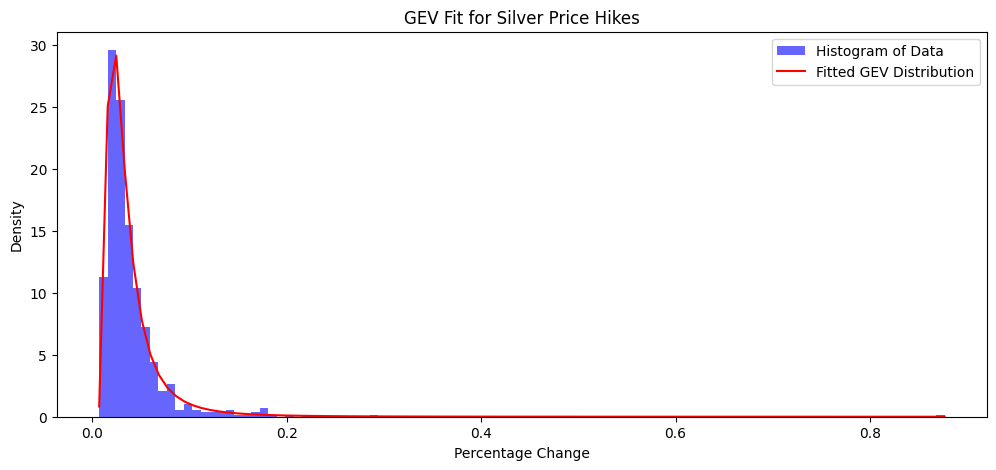

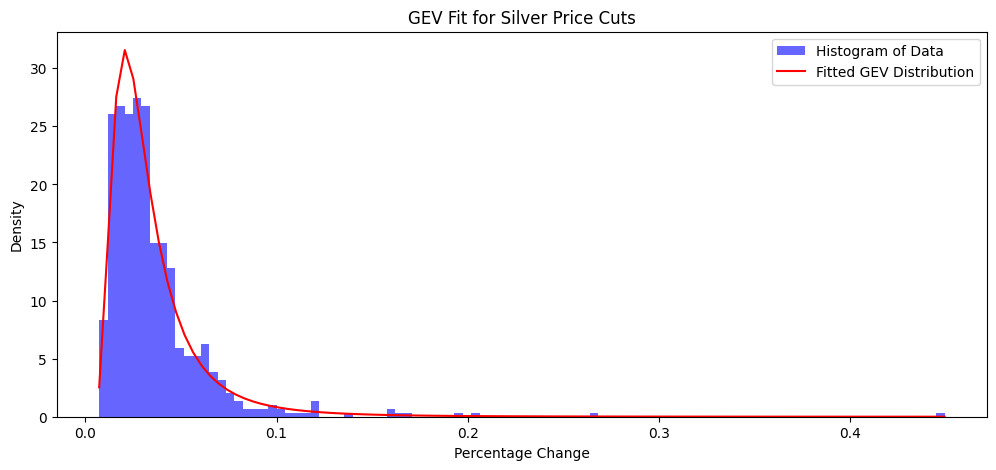

In [12]:
# Visualizing the Fitted GEV Distribution
def plot_gev_fits(data, gev_params, title):
    plt.figure(figsize=(12, 5))
    x = np.linspace(min(data), max(data), 100)
    pdf = genextreme.pdf(x, *gev_params)
    plt.hist(data, bins=100, density=True, alpha=0.6, color='b', label='Histogram of Data')
    plt.plot(x, pdf, 'r-', label='Fitted GEV Distribution')
    plt.title(title)
    plt.xlabel('Percentage Change')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

plot_gev_fits(block_maxima_hikes, gev_params_hikes, 'GEV Fit for Silver Price Hikes')
plot_gev_fits(-block_minima_cuts, gev_params_cuts, 'GEV Fit for Silver Price Cuts')

The GEV model captures the overall distribution well, especially for moderate price hikes and cuts.     
However, for very extreme jumps, the fit slightly underestimates the probability, suggesting occasional large price spikes/drops may be more likely than GEV predicts.

---

## Peak Over Threshold (POT) Method Using GPD

1. Identifying Extreme Events
- Sets a threshold at 90th percentile for hikes (positive spikes).
- Sets a threshold at 10th percentile for cuts (negative spikes).
- Extracts only extreme events beyond these thresholds.

2. Fitting the Generalized Pareto Distribution (GPD)
- GPD is used for modeling extreme exceedances.
- Like GEV, it has shape, location, and scale parameters.

3. Q-Q Plots for GPD Fit
- Again, checks how well theoretical and observed quantiles align.
- A good fit means the GPD accurately models extreme silver price jumps.

GPD Parameters (Hikes - Shape, Location, Scale): (np.float64(0.3247072616860175), np.float64(0.020592484964940504), np.float64(0.012510560235295606))
GPD Parameters (Cuts - Shape, Location, Scale): (np.float64(0.13233156255394798), np.float64(0.021177685887371248), np.float64(0.013020573938509951))


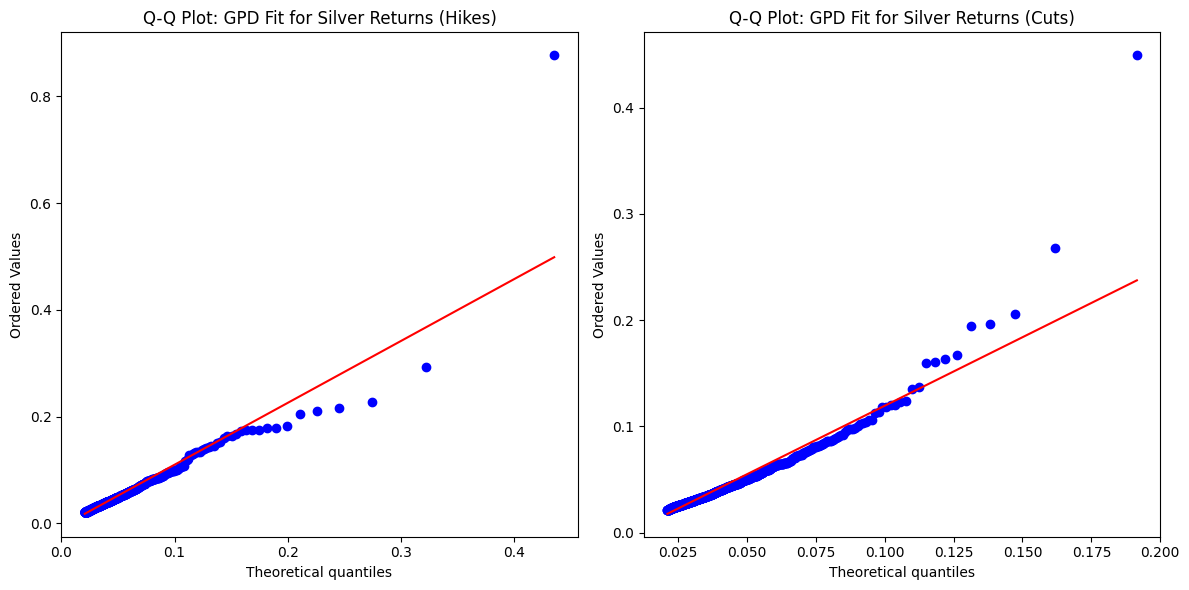

In [13]:
# Peak Over Threshold (POT) Method for hikes
threshold_pos = df['rate_change'].quantile(0.90)
extreme_hikes = df[df['rate_change'] > threshold_pos]['rate_change']
gpd_params_hikes = genpareto.fit(extreme_hikes)
print("GPD Parameters (Hikes - Shape, Location, Scale):", gpd_params_hikes)

# Peak Over Threshold (POT) Method for cuts
threshold_neg = df['rate_change'].quantile(0.10)
extreme_cuts = df[df['rate_change'] < threshold_neg]['rate_change']
gpd_params_cuts = genpareto.fit(-extreme_cuts)
print("GPD Parameters (Cuts - Shape, Location, Scale):", gpd_params_cuts)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Q-Q Plot for GPD Fit (Extreme Hikes)
scipy.stats.probplot(extreme_hikes, dist=genpareto, sparams=gpd_params_hikes, plot=axes[0])
axes[0].set_title("Q-Q Plot: GPD Fit for Silver Returns (Hikes)")
# Q-Q Plot for GPD Fit (Extreme Cuts)
scipy.stats.probplot(-extreme_cuts, dist=genpareto, sparams=gpd_params_cuts, plot=axes[1])
axes[1].set_title("Q-Q Plot: GPD Fit for Silver Returns (Cuts)")
plt.tight_layout()
plt.show()

1. spikes

ξ = 0.325 (Positive Shape Parameter) → Suggests a heavy-tailed distribution, meaning large price hikes are relatively frequent.
μ = 0.0206 (2.06%) → Extreme price hikes are defined as returns above 2.06%.
σ = 0.0125 → The spread of extreme hikes is 1.25%, meaning silver price spikes vary around this amount.

Since ξ > 0, silver price hikes follow a heavy-tailed distribution, meaning large jumps in silver prices are more frequent than expected in a normal market.
The higher the shape parameter, the more likely we are to see extreme hikes.
The threshold (2.06%) means that only price changes above this level were used in the GPD model.

The data follows the red line well in the middle but deviates in the upper tail, meaning the GPD slightly underestimates the most extreme hikes.

2. cuts

ξ = 0.132 (Positive Shape Parameter) → Suggests a moderately heavy tail, meaning large price crashes are somewhat frequent, but less so than hikes.     
μ = 0.0212 (2.12%) → Extreme price cuts are defined as returns below -2.12%.        
σ = 0.0130 → The spread of extreme cuts is 1.3%, similar to hikes.      

ξ > 0 suggests that silver price crashes also follow a heavy-tailed distribution, but the tail is less extreme than hikes.  
Extreme silver price crashes are less frequent than hikes, but they still occur more often than a normal distribution would suggest.    
The threshold (-2.12%) means that only price changes below this level were considered extreme.  

The fit is slightly better than for hikes, but some upper extreme values deviate, meaning the most severe price crashes are slightly underestimated by the GPD model.



## Histogram vs. Fitted GPD Distribution
- Shows how well GPD captures the tail behavior.
- Helps predict the likelihood of future extreme hikes/cuts.

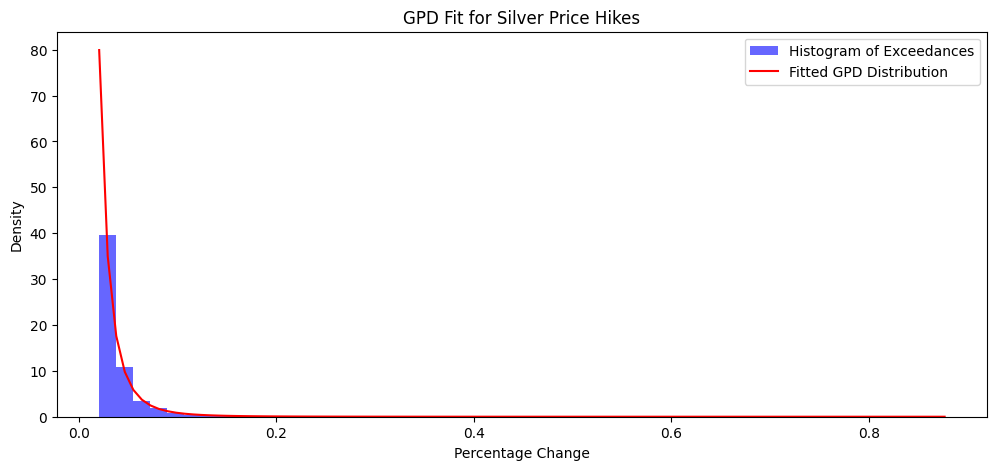

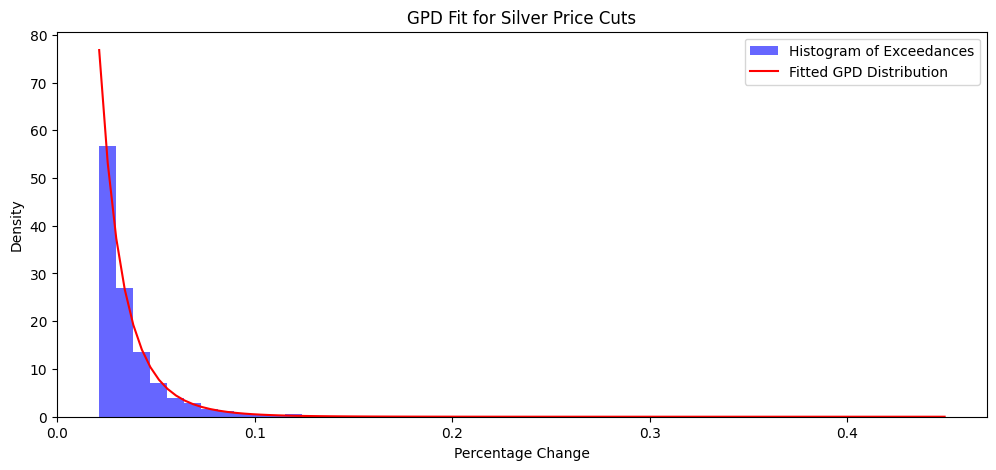

In [14]:
# Visualizing the Fitted GPD Distribution
def plot_gpd_fits(data, gpd_params, title):
    plt.figure(figsize=(12, 5))
    x = np.linspace(min(data), max(data), 100)
    pdf = genpareto.pdf(x, *gpd_params)
    plt.hist(data, bins=50, density=True, alpha=0.6, color='b', label='Histogram of Exceedances')
    plt.plot(x, pdf, 'r-', label='Fitted GPD Distribution')
    plt.title(title)
    plt.xlabel('Percentage Change')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

plot_gpd_fits(extreme_hikes, gpd_params_hikes, 'GPD Fit for Silver Price Hikes')
plot_gpd_fits(-extreme_cuts, gpd_params_cuts, 'GPD Fit for Silver Price Cuts')

Both price hikes and cuts follow a heavy-tailed distribution, meaning extreme events occur more often than in a normal market.      
Extreme hikes are more common than extreme crashes, meaning silver prices spike more often than they collapse.

---

## Conclusion

Our analysis of **extreme silver price movements** using **two different statistical methods—GEV (Generalized Extreme Value) and GPD (Generalized Pareto Distribution)**—led to seemingly different conclusions:

1. **GEV (Block Maxima Method)** produced a **negative shape parameter (ξ < 0)**, suggesting that extreme silver price hikes and crashes are **bounded**, meaning there is a natural limit to how large these movements can be.
2. **GPD (Peak Over Threshold Method)** produced a **positive shape parameter (ξ > 0)**, indicating that **smaller but still extreme price movements occur frequently**, and follow a **heavy-tailed distribution**, meaning large jumps or drops happen more often than in a normal distribution.

While these conclusions may seem contradictory, they are actually complementary. The **GEV model only looks at the single most extreme event per period**, which smooths out variability and suggests that the **largest possible price movements are limited**. On the other hand, the **GPD model captures all exceedances above a threshold**, revealing that **extreme movements—though not necessarily the absolute largest—are frequent and follow a heavy tail**.

### What Does This Mean?
- **Silver price extremes do not grow indefinitely**, meaning catastrophic, unlimited surges or crashes are unlikely (**GEV finding**).
- **However, smaller but still significant extreme movements occur more often than a normal distribution would predict** (**GPD finding**).
- **Risk models should incorporate both findings**:
  - **GEV is useful for modeling the maximum expected move in a given period (e.g., yearly max drawdowns).**
  - **GPD is better for short-term risk estimation, such as daily or weekly extreme returns.**

Understanding **both the frequency and magnitude of extreme silver price movements** is crucial for financial risk management. While extreme movements have an upper bound, they **occur more often than a normal market would predict**, highlighting the need for **robust risk models** that account for both **bounded extremes and heavy-tailed behavior**.
